In [142]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller


In [143]:
df=pd.read_csv("../Data.csv",index_col="Date")
df.index=pd.to_datetime(df.index)

In [144]:
close_series = df['Close']


In [145]:
close_series

Date
2015-02-09     26.766184
2015-02-10     27.280405
2015-02-11     27.919817
2015-02-12     28.273066
2015-02-13     28.411680
                 ...    
2025-02-03    228.009995
2025-02-04    232.800003
2025-02-05    232.470001
2025-02-06    233.220001
2025-02-07    227.630005
Name: Close, Length: 2516, dtype: float64

In [146]:
Close_diff = close_series.diff()
Close_diff = close_series.dropna()


In [147]:
def adf_test(series):
    series = series.dropna()

    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("✅ Données stationnaires")
    else:
        print("❌ Données NON stationnaires")

In [148]:
adf_test(close_series)


ADF Statistic: 0.283475759488255
p-value: 0.976573532441623
❌ Données NON stationnaires


In [149]:
adf_test(Close_diff)


ADF Statistic: 0.283475759488255
p-value: 0.976573532441623
❌ Données NON stationnaires


In [150]:
Close_diff2 = Close_diff.diff().dropna()
print("\nÉtape 3: Deuxième différenciation")
adf_test(Close_diff2)


Étape 3: Deuxième différenciation
ADF Statistic: -15.885644923857054
p-value: 8.656542388073247e-29
✅ Données stationnaires


In [151]:
Close_diff2

Date
2015-02-10    0.514221
2015-02-11    0.639412
2015-02-12    0.353249
2015-02-13    0.138615
2015-02-17    0.167685
                ...   
2025-02-03   -7.990005
2025-02-04    4.790009
2025-02-05   -0.330002
2025-02-06    0.750000
2025-02-07   -5.589996
Name: Close, Length: 2515, dtype: float64

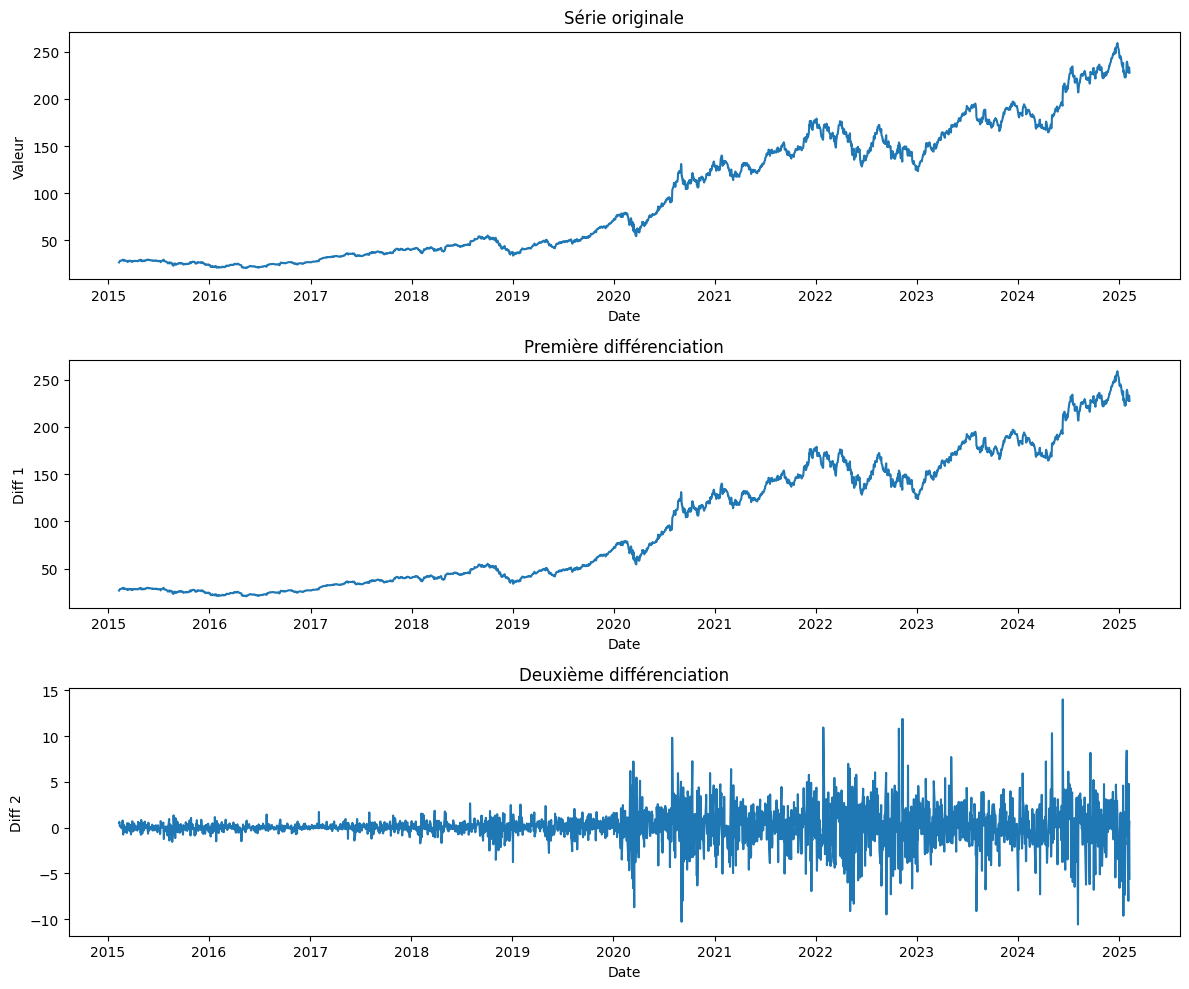

In [152]:

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

# Série originale
ax1.plot(close_series)
ax1.set_title('Série originale')
ax1.set_xlabel('Date')
ax1.set_ylabel('Valeur')

# Première différenciation
ax2.plot(Close_diff)
ax2.set_title('Première différenciation')
ax2.set_xlabel('Date')
ax2.set_ylabel('Diff 1')

# Deuxième différenciation
ax3.plot(Close_diff2)
ax3.set_title('Deuxième différenciation')
ax3.set_xlabel('Date')
ax3.set_ylabel('Diff 2')

plt.tight_layout()
plt.show()


In [153]:
# 🎯 2. Division Train/Test

train_data=close_series[0:int(len(close_series)*0.8)]
test_data=close_series[int(len(close_series)*0.8):len(close_series)]


In [154]:
train_data 

Date
2015-02-09     26.766184
2015-02-10     27.280405
2015-02-11     27.919817
2015-02-12     28.273066
2015-02-13     28.411680
                 ...    
2023-01-30    141.511856
2023-01-31    142.788422
2023-02-01    143.916595
2023-02-02    149.250519
2023-02-03    152.892212
Name: Close, Length: 2012, dtype: float64

In [155]:
test_data

Date
2023-02-06    150.151016
2023-02-07    153.040649
2023-02-08    150.339081
2023-02-09    149.299973
2023-02-10    149.666687
                 ...    
2025-02-03    228.009995
2025-02-04    232.800003
2025-02-05    232.470001
2025-02-06    233.220001
2025-02-07    227.630005
Name: Close, Length: 504, dtype: float64

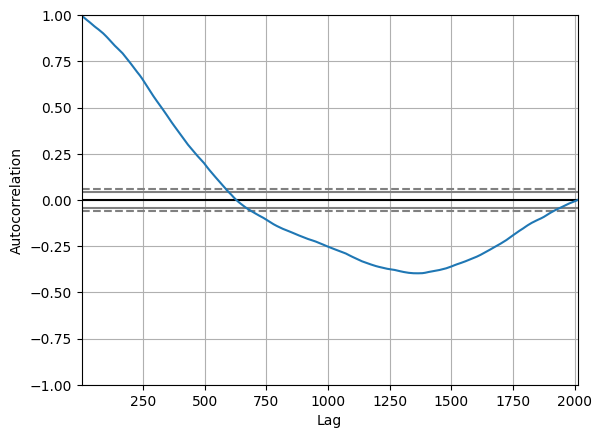

In [156]:
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
autocorrelation_plot(train_data)
pyplot.show()

lag = 600

In [ ]:
# 🎯 4. Modèle AutoReg (AR) avec lag=600
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(train_data, lags=600)
model_fit = model.fit()
coef = model_fit.params
print("\n📌 Coefficients du modèle AR(300) :\n", coef)





📌 Coefficients du modèle AR(300) :
 const         0.048858
Close.L1      0.957066
Close.L2      0.085675
Close.L3     -0.112453
Close.L4      0.020166
                ...   
Close.L596   -0.228929
Close.L597    0.201087
Close.L598   -0.303707
Close.L599    0.266594
Close.L600   -0.046294
Length: 601, dtype: float64


In [158]:

# 🎯 5a. Prédiction avec `predict()`
predictions1 = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
results = pd.DataFrame({
    'Predicted': predictions1.values,
    'Expected': test_data
}, index=test_data.index)

In [159]:
# Afficher les premières comparaisons
print("Comparaison des 10 premières prédictions vs valeurs réelles:")
print(results.head(10))

Comparaison des 10 premières prédictions vs valeurs réelles:
             Predicted    Expected
Date                              
2023-02-06  150.853662  150.151016
2023-02-07  164.786872  153.040649
2023-02-08  170.286372  150.339081
2023-02-09  176.600715  149.299973
2023-02-10  162.254376  149.666687
2023-02-13  169.844011  152.481415
2023-02-14  176.605815  151.837204
2023-02-15  175.985487  153.948273
2023-02-16  178.594064  152.342667
2023-02-17  177.407512  151.192993


In [160]:
# 🎯 6. Évaluation des performances (RMSE)
from sklearn.metrics import mean_squared_error
import numpy as np

rmse1 = np.sqrt(mean_squared_error(test_data, predictions1))


In [161]:
print(f"\n✅ RMSE (AutoReg.predict) : {rmse1:.4f}")



✅ RMSE (AutoReg.predict) : 35.3740


In [162]:
residuals = test_data.values - predictions1.values



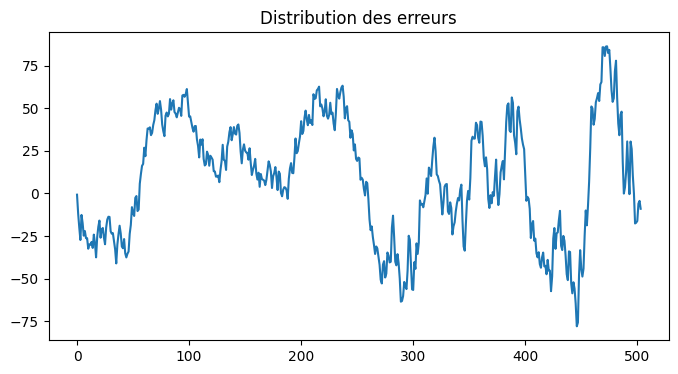

In [163]:

plt.figure(figsize=(8,4))
plt.plot(residuals)
plt.title("Distribution des erreurs")
plt.show()

On remarque que cet erreur n est pas purement white noise , donc on va appliquer MA 

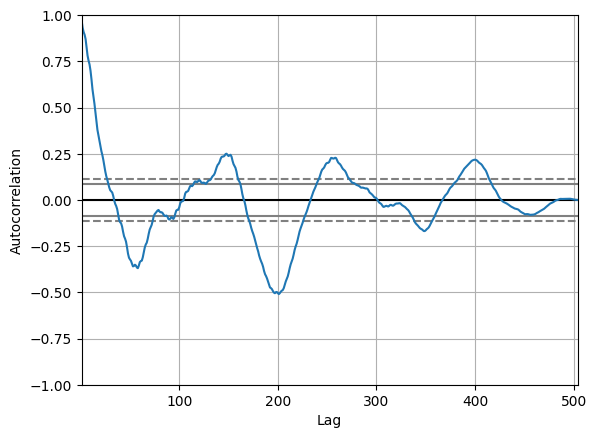

In [169]:
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
autocorrelation_plot(residuals)
pyplot.show()

lag = 50

In [172]:
# 🎯 4. Modèle AutoReg (AR) avec lag=50
from statsmodels.tsa.ar_model import AutoReg

model_error = AutoReg(train_data, lags=50)
model_fit_error = model.fit()
coef_error = model_fit.params
print("\n📌 Coefficients du modèle AR(50) :\n", coef)


📌 Coefficients du modèle AR(50) :
 const         0.048858
Close.L1      0.957066
Close.L2      0.085675
Close.L3     -0.112453
Close.L4      0.020166
                ...   
Close.L596   -0.228929
Close.L597    0.201087
Close.L598   -0.303707
Close.L599    0.266594
Close.L600   -0.046294
Length: 601, dtype: float64


In [173]:

# 🎯 5a. Prédiction avec `predict()`
predictions_error = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
results_error = pd.DataFrame({
    'Predicted': predictions_error.values,
    'Expected': test_data
}, index=test_data.index)

In [174]:
# Afficher les premières comparaisons
print("Comparaison des 10 premières prédictions vs valeurs réelles:")
print(results_error.head(10))

Comparaison des 10 premières prédictions vs valeurs réelles:
             Predicted    Expected
Date                              
2023-02-06  150.853662  150.151016
2023-02-07  164.786872  153.040649
2023-02-08  170.286372  150.339081
2023-02-09  176.600715  149.299973
2023-02-10  162.254376  149.666687
2023-02-13  169.844011  152.481415
2023-02-14  176.605815  151.837204
2023-02-15  175.985487  153.948273
2023-02-16  178.594064  152.342667
2023-02-17  177.407512  151.192993


In [175]:
residuals_err = test_data.values - predictions_error.values

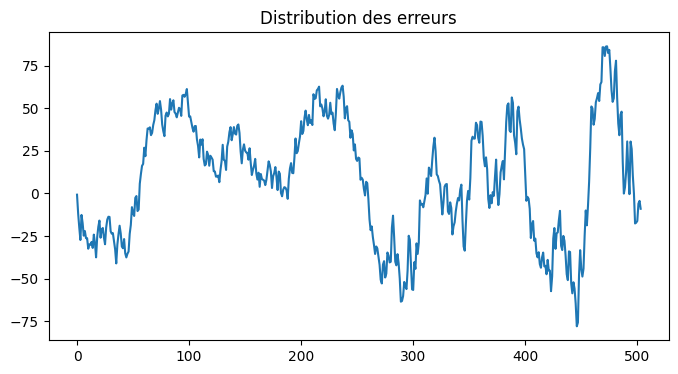

In [177]:
plt.figure(figsize=(8,4))
plt.plot(residuals_err)
plt.title("Distribution des erreurs")
plt.show()

## ARIMA

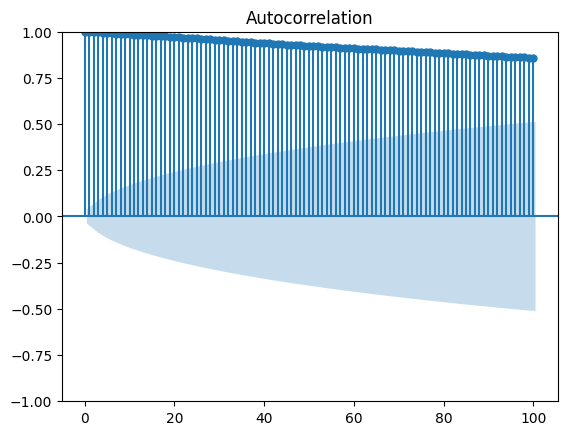

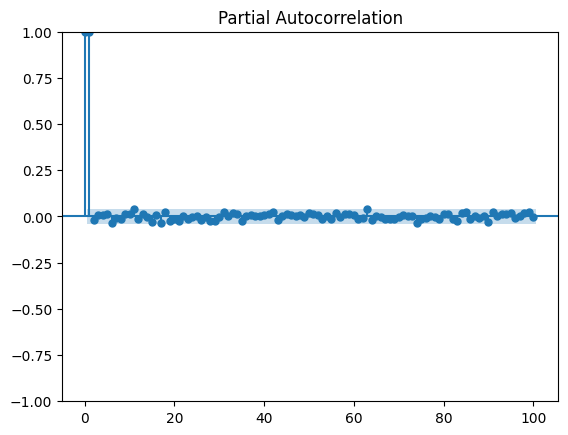

In [164]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(close_series, lags=100)
plt.show()

plot_pacf(close_series, lags=100)
plt.show()

In [165]:
from statsmodels.tsa.arima.model import ARIMA
import itertools
def grid_search_arima(train, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q))
            model_fit = model.fit()
            aic = model_fit.aic
            print(f"model aic: {aic} || best score: {best_score}")
            if aic < best_score:
                best_score, best_cfg = aic, (p, d, q)
        except:
            continue
    return best_cfg, best_score

In [166]:
import warnings
warnings.filterwarnings("ignore")
#j'ai ajouter ce block de code pour ignorer les warnings 

In [123]:
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)

best_cfg, best_score = grid_search_arima(train_data, p_values, d_values, q_values)
print(f"Meilleurs paramètres ARIMA: {best_cfg} avec AIC: {best_score}")

model aic: 9868.935968591242 || best score: inf
model aic: 8578.767045509543 || best score: 9868.935968591242
model aic: 7640.34881309037 || best score: 8578.767045509543
model aic: 6968.854423891284 || best score: 7640.34881309037
model aic: 6554.00103059647 || best score: 6968.854423891284
model aic: 4793.834457579609 || best score: 6554.00103059647
model aic: 4794.77276992479 || best score: 4793.834457579609
model aic: 4796.508642384028 || best score: 4793.834457579609
model aic: 4798.42780211452 || best score: 4793.834457579609
model aic: 4800.203977926494 || best score: 4793.834457579609
model aic: 5516.672862560072 || best score: 4793.834457579609
model aic: 4797.224143093525 || best score: 4793.834457579609
model aic: 4798.117427706867 || best score: 4793.834457579609
model aic: 4799.814237311417 || best score: 4793.834457579609
model aic: 4801.716115670828 || best score: 4793.834457579609
model aic: 4807.532354841403 || best score: 4793.834457579609
model aic: 4808.560680157334

In [125]:
# Validation par glissement (Walk Forward Validation)
history = list(train_data)
predictions = list()
errors=list()
for t in range(len(test_data)):
    model = ARIMA(history, order=best_cfg)  # Utilisation des paramètres optimisés
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test_data.iloc[t])  # Mise à jour avec la vraie valeur
    print(f">Predicted=%.3f, Expected=%.3f" % (yhat, test_data.iloc[t]))
    errors.append(test_data.iloc[t]-yhat)

>Predicted=188.153, Expected=188.487
>Predicted=188.665, Expected=187.402
>Predicted=187.297, Expected=188.169
>Predicted=188.206, Expected=186.475
>Predicted=186.507, Expected=184.373
>Predicted=184.330, Expected=183.486
>Predicted=183.577, Expected=183.197
>Predicted=183.078, Expected=181.653
>Predicted=181.812, Expected=180.905
>Predicted=180.751, Expected=181.663
>Predicted=181.753, Expected=183.705
>Predicted=183.615, Expected=181.862
>Predicted=181.919, Expected=180.507
>Predicted=180.489, Expected=181.972
>Predicted=181.870, Expected=180.766
>Predicted=180.909, Expected=180.098
>Predicted=179.982, Expected=179.012
>Predicted=179.163, Expected=174.469
>Predicted=174.360, Expected=169.507
>Predicted=169.626, Expected=168.510
>Predicted=168.453, Expected=168.391
>Predicted=168.400, Expected=170.114
>Predicted=170.139, Expected=172.127
>Predicted=172.024, Expected=172.605
>Predicted=172.742, Expected=170.513
>Predicted=170.338, Expected=172.376
>Predicted=172.611, Expected=171.998
>

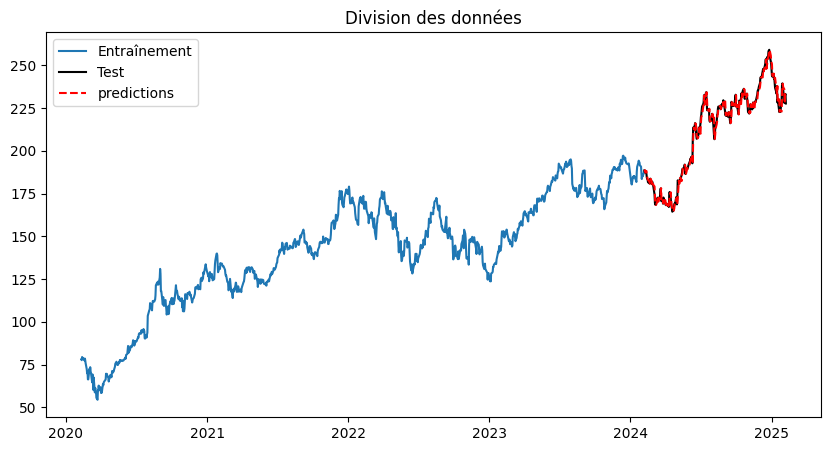

In [137]:
plt.figure(figsize=(10, 5))
plt.plot(train_data.index, train_data.values, label='Entraînement')
plt.plot(test_data.index, test_data.values, label='Test', color='black')
plt.plot(test_data.index, predictions, label='predictions', color='red' , linestyle = "--")
plt.title("Division des données")
plt.legend()
plt.show()

In [130]:
rmse = np.sqrt(mean_squared_error(test_data, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 3.146


In [131]:
errors=np.array(errors)

Text(0.5, 1.0, 'Les erreurs effectuées lors de la prediction')

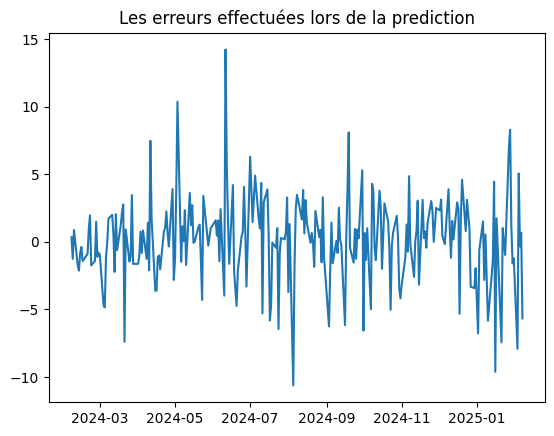

In [134]:
plt.plot(test_data.index,errors)
plt.title("Les erreurs effectuées lors de la prediction")